# Question 3

1. Given a start-point, a goal point, and two obstacles (defined in the provided code), implement the artificial potential field method to plan a collision-free trajectory from the starting point to the target point, while avoiding the two obstacles.
2. Visualize the planned trajectory, clearly showing the start point, target point, obstacles, and the path generated by your planner.

In [51]:
# import necessary python packages
import torch
import matplotlib.pyplot as plt

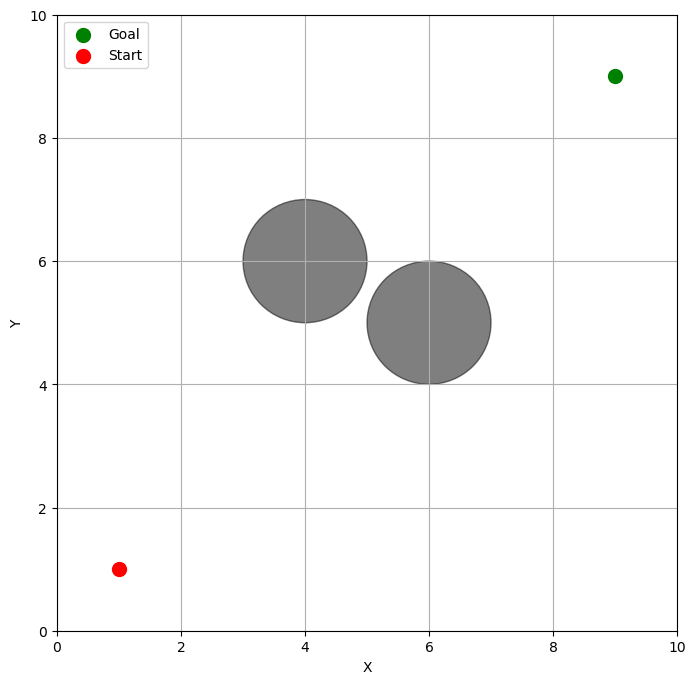

In [52]:
# Parameters for the environment
Goal = torch.tensor([9.0, 9.0], dtype=torch.float32)  # goal position
Start = torch.tensor([1.0, 1.0], dtype=torch.float32)  # start position

Obstacles = torch.tensor([[4.0, 6.0], [6.0, 5.0]], dtype=torch.float32)  # obstacle positions
Obstacle_radius = 1  # radius of the circular obstacles
Threshold = 4 # Threshold (i.e., rho_0), typically larger than Obstacle_radius

# Plotting the environment
plt.figure(figsize=(8, 8))
plt.scatter(Goal[0], Goal[1], color="green", label="Goal", s=100)
plt.scatter(Start[0], Start[1], color="red", label="Start", s=100)
for obs in Obstacles.numpy():
    circle = plt.Circle((obs[0], obs[1]), Obstacle_radius, color="black", alpha=0.5)
    plt.gca().add_artist(circle)
# Create a grid environment
grid_size = 10  # size of the grid
plt.xlim(0, grid_size)
plt.ylim(0, grid_size)
plt.xlabel("X")
plt.ylabel("Y")
plt.title("")
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

In [53]:
# parameters for attractive force and repulsive force
k_att = 1.0  # attractive constant
k_rep = 100.0  # repulsive constant

# Attractive potential field (towards goal)
def attractive_potential(x, goal):
    return 0.5 * k_att * torch.norm(x - goal) ** 2

# Repulsive potential field (away from obstacles)
def repulsive_potential(x, obstacles, threshold):
    rep_total = 0
    for obs in obstacles:
        dist = torch.norm(x - obs)
        if dist <= threshold:
            potential = 0.5 * k_rep * (1.0 / dist - 1.0 / threshold) ** 2
        else:
            potential = torch.tensor(0.0)  # zero if distance > threshold (means the robot is far from the obstacle)
        rep_total += potential
    return rep_total


[notice] A new release of pip available: 22.3 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


  Using cached torch-2.6.0-cp311-cp311-win_amd64.whl (204.2 MB)
  Using cached filelock-3.17.0-py3-none-any.whl (16 kB)
  Using cached networkx-3.4.2-py3-none-any.whl (1.7 MB)
  Using cached jinja2-3.1.6-py3-none-any.whl (134 kB)
  Using cached fsspec-2025.3.0-py3-none-any.whl (193 kB)
  Using cached sympy-1.13.1-py3-none-any.whl (6.2 MB)
  Using cached mpmath-1.3.0-py3-none-any.whl (536 kB)
  Using cached MarkupSafe-3.0.2-cp311-cp311-win_amd64.whl (15 kB)


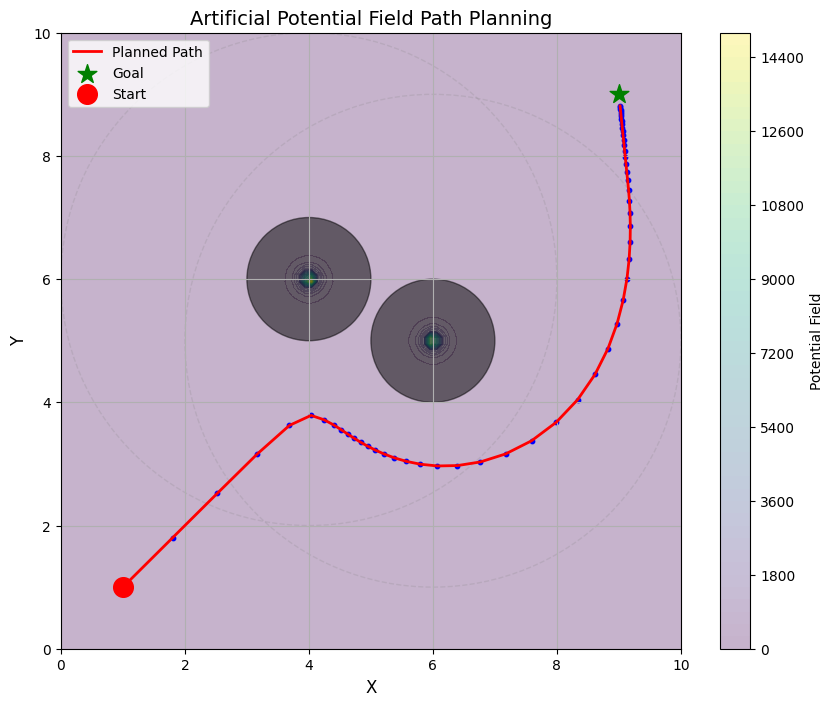

Path length: 56 points
Final position: (9.02, 8.81)
Distance to goal: 0.1895


In [3]:
!pip install torch

import torch
import matplotlib.pyplot as plt
import numpy as np

# Parameters for the environment
Goal = torch.tensor([9.0, 9.0], dtype=torch.float32)  # goal position
Start = torch.tensor([1.0, 1.0], dtype=torch.float32)  # start position
Obstacles = torch.tensor([[4.0, 6.0], [6.0, 5.0]], dtype=torch.float32)  # obstacle positions
Obstacle_radius = 1  # radius of the circular obstacles
Threshold = 4  # Threshold (i.e., rho_0), typically larger than Obstacle_radius

# parameters for attractive force and repulsive force
k_att = 1.0  # attractive constant
k_rep = 100.0  # repulsive constant

# Attractive potential field (towards goal)
def attractive_potential(x, goal):
    return 0.5 * k_att * torch.norm(x - goal) ** 2

# Repulsive potential field (away from obstacles)
def repulsive_potential(x, obstacles, threshold):
    rep_total = 0
    for obs in obstacles:
        dist = torch.norm(x - obs)
        if dist <= threshold:
            potential = 0.5 * k_rep * (1.0 / dist - 1.0 / threshold) ** 2
        else:
            potential = torch.tensor(0.0)  # zero if distance > threshold (means the robot is far from the obstacle)
        rep_total += potential
    return rep_total

# Total potential field
def total_potential(x, goal, obstacles, threshold):
    return attractive_potential(x, goal) + repulsive_potential(x, obstacles, threshold)

# Gradient of the attractive potential
def attractive_gradient(x, goal):
    return k_att * (x - goal)

# Gradient of the repulsive potential
def repulsive_gradient(x, obstacles, threshold):
    grad = torch.zeros_like(x)
    for obs in obstacles:
        dist = torch.norm(x - obs)
        if dist <= threshold:
            # Gradient of repulsive potential
            grad += k_rep * (1.0 / threshold - 1.0 / dist) * (1.0 / dist**2) * (x - obs) / dist
    return grad

# Gradient of the total potential
def total_gradient(x, goal, obstacles, threshold):
    return attractive_gradient(x, goal) + repulsive_gradient(x, obstacles, threshold)

# Plan path using gradient descent
def plan_path(start, goal, obstacles, threshold, step_size=0.1, max_steps=1000, goal_threshold=0.2):
    path = [start]
    current = start.clone()
    
    for _ in range(max_steps):
        # Calculate gradient
        grad = total_gradient(current, goal, obstacles, threshold)
        
        # Move in the opposite direction of the gradient
        current = current - step_size * grad
        
        # Add current position to path
        path.append(current.clone())
        
        # Check if goal is reached
        if torch.norm(current - goal) < goal_threshold:
            break
    
    return torch.stack(path)

# Plan the path
path = plan_path(Start, Goal, Obstacles, Threshold)

# Create a grid for potential field visualization
x = np.linspace(0, 10, 100)
y = np.linspace(0, 10, 100)
X, Y = np.meshgrid(x, y)
Z = np.zeros_like(X)

# Calculate potential field values for visualization
for i in range(len(x)):
    for j in range(len(y)):
        pos = torch.tensor([X[j, i], Y[j, i]], dtype=torch.float32)
        Z[j, i] = total_potential(pos, Goal, Obstacles, Threshold).item()

# Plotting
plt.figure(figsize=(10, 8))

# Plot potential field contour
contour = plt.contourf(X, Y, Z, levels=50, cmap='viridis', alpha=0.3)
plt.colorbar(contour, label='Potential Field')

# Plot the path
path_np = path.detach().numpy()
plt.plot(path_np[:, 0], path_np[:, 1], 'r-', linewidth=2, label='Planned Path')
plt.scatter(path_np[:, 0], path_np[:, 1], c='blue', s=10)

# Plot start, goal, and obstacles
plt.scatter(Goal[0], Goal[1], color="green", marker='*', s=200, label="Goal")
plt.scatter(Start[0], Start[1], color="red", marker='o', s=200, label="Start")

for obs in Obstacles.numpy():
    circle = plt.Circle((obs[0], obs[1]), Obstacle_radius, color="black", alpha=0.5)
    plt.gca().add_artist(circle)
    # Draw the threshold circle
    threshold_circle = plt.Circle((obs[0], obs[1]), Threshold, color="gray", alpha=0.2, linestyle='--', fill=False)
    plt.gca().add_artist(threshold_circle)

# Set plot limits
plt.xlim(0, 10)
plt.ylim(0, 10)
plt.xlabel("X", fontsize=12)
plt.ylabel("Y", fontsize=12)
plt.title("Artificial Potential Field Path Planning", fontsize=14)
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

# Print some statistics
print(f"Path length: {len(path)} points")
print(f"Final position: ({path[-1][0]:.2f}, {path[-1][1]:.2f})")
print(f"Distance to goal: {torch.norm(path[-1] - Goal):.4f}")

# Discuss the results in your report

Experiment with different step size or learning rate for gradient descent, evaluate their performance. Then, analyze and discuss your findings in the report. You do not need to write code for this section—focus on interpreting and explaining the results in your discussion.

In [55]:
# TODO: discuss your results in your report, no code required here.